In [1]:
# %%
# =================================================================================
# 1. 초기 설정 (Setup)
# =================================================================================
import os
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import (
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    get_linear_schedule_with_warmup
)
from peft import get_peft_model, LoraConfig, TaskType, PeftModel, PeftConfig
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, precision_recall_fscore_support,
    confusion_matrix, classification_report
)
import torch.nn.functional as F
from tqdm.auto import tqdm
import re
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import shutil

os.environ["HF_HOME"] = "/home/work/fm/huggingface"

In [6]:
# %%
# =================================================================================
# 2. 하이퍼파라미터 및 전체 설정
# =================================================================================
# --- 실행 모드 ---
DO_TRAINING = False  # True: 훈련부터 시작 | False: 저장된 모델로 추론만 실행

# --- 경로 설정 ---
train_csv  = "hc3_train.csv"
test_csv   = "hc3_test.csv"
model_name = "google-t5/t5-base"
checkpoint_dir = "t5_hc3_last" # 결과 저장 폴더
submission_file = "submission_t5.csv"      # 생성될 제출 파일 이름

# --- 레이블 매핑 ---
label_map = {0: "human", 1: "ai"}
inverse_label_map = {v: k for k, v in label_map.items()}

# --- 학습 하이퍼파라미터 ---
batch_size      = 64
learning_rate   = 3e-5
num_epochs      = 10
max_length      = 256
seed            = 42
early_stopping_patience = 999

# --- 추론 전용 설정 (DO_TRAINING = False 일 때 사용) ---
ADAPTER_PATH_FOR_INFERENCE = "/home/work/fm/t5_hc3_last/epoch9_f1_0.9872"

In [7]:
# %%
# =================================================================================
# 3. 유틸리티, 데이터셋 클래스 정의
# =================================================================================
def set_seed(seed=42):
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    np.random.seed(seed); random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def clean_text(text):
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z0-9\s.!?\']', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

class TextDataset(Dataset):
    def __init__(self, df, tokenizer, max_length=512, is_train=True):
        self.data = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.is_train = is_train

    def __len__(self): return len(self.data)

    def __getitem__(self, idx):
        item = self.data.loc[idx]
        text = item['text']
        input_text = f"classify the following text as human or ai: {text}"
        input_encoding = self.tokenizer(
            input_text, max_length=self.max_length, padding="max_length",
            truncation=True, return_tensors="pt"
        )
        output = {
            'input_ids': input_encoding['input_ids'].squeeze(),
            'attention_mask': input_encoding['attention_mask'].squeeze(),
        }
        if self.is_train:
            label = label_map[int(item['label'])]
            target_encoding = self.tokenizer(
                label, max_length=4, padding="max_length",
                truncation=True, return_tensors="pt"
            )
            labels = target_encoding['input_ids'].squeeze()
            labels[labels == self.tokenizer.pad_token_id] = -100
            output['labels'] = labels
        return output

In [8]:
# %%
# =================================================================================
# 4. 모든 실행 함수 정의
# =================================================================================

# --- 훈련 함수 ---
def train(model, loader, optimizer, scheduler, device):
    model.train()
    total_loss = 0
    for batch in tqdm(loader, desc="Training", leave=False):
        optimizer.zero_grad()
        outputs = model(
            input_ids=batch['input_ids'].to(device),
            attention_mask=batch['attention_mask'].to(device),
            labels=batch['labels'].to(device)
        )
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
    return {"loss": total_loss / len(loader)}

# --- 검증(평가) 함수 ---
def evaluate(model, loader, device, tokenizer):
    model.eval()
    all_preds_text, all_labels_text = [], []
    with torch.no_grad():
        for batch in tqdm(loader, desc="Validation", leave=False):
            labels = batch['labels'].clone().to(device)
            labels[labels == -100] = tokenizer.pad_token_id
            generated_ids = model.generate(
                input_ids=batch['input_ids'].to(device),
                attention_mask=batch['attention_mask'].to(device), max_length=4
            )
            preds = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
            labels_text = tokenizer.batch_decode(labels, skip_special_tokens=True)
            all_preds_text.extend(preds)
            all_labels_text.extend(labels_text)
    cleaned_preds = ["ai" if "ai" in p.lower() else "human" for p in all_preds_text]
    accuracy = accuracy_score(all_labels_text, cleaned_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels_text, cleaned_preds, average='binary', pos_label="ai", zero_division=0
    )
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

# --- 메인 훈련 루프 ---
def run_training():
    set_seed(seed)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # --- 데이터 준비, 모델 로드 등 (이전과 동일) ---
    df = pd.read_csv(train_csv)
    df = df.dropna(subset=['text', 'label'])
    df['text'] = df['text'].astype(str).apply(clean_text)
    df = df[df['text'].str.strip() != '']
    df = df.drop_duplicates(subset=['text'], keep='first')
    train_df, val_df = train_test_split(df, test_size=0.3, random_state=seed, stratify=df['label'])

    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSeq2SeqLM.from_pretrained(model_name, torch_dtype=torch.bfloat16)
    peft_config = LoraConfig(
        task_type=TaskType.SEQ_2_SEQ_LM, r=8, lora_alpha=16, lora_dropout=0.05, target_modules=["q", "v"]
    )
    model = get_peft_model(model, peft_config).to(device)
    
    train_dataset = TextDataset(train_df, tokenizer, max_length)
    val_dataset = TextDataset(val_df, tokenizer, max_length)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    optimizer = AdamW(model.parameters(), lr=learning_rate)
    total_steps = len(train_loader) * num_epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=int(total_steps*0.1), num_training_steps=total_steps)
    
    if not os.path.exists(checkpoint_dir): os.makedirs(checkpoint_dir)

    # --- 훈련 루프 ---
    best_f1 = 0.0
    patience_counter = 0
    history = []
    
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        train_metrics = train(model, train_loader, optimizer, scheduler, device)
        val_metrics = evaluate(model, val_loader, device, tokenizer)
        
        epoch_results = {
            "Epoch": epoch + 1, "Train Loss": train_metrics['loss'],
            **{f"Val {k.capitalize()}": v for k, v in val_metrics.items()}
        }
        history.append(epoch_results)
        
        print(f"Train Loss: {train_metrics['loss']:.4f}")
        print(f"Val Acc: {val_metrics['accuracy']:.4f} | Precision: {val_metrics['precision']:.4f} | Recall: {val_metrics['recall']:.4f} | F1-Score: {val_metrics['f1']:.4f}")
        print("-" * 80)
        
        # 1. 최고 성능 F1-score와 조기 종료 카운터는 계속 추적
        current_f1 = val_metrics['f1']
        if current_f1 > best_f1:
            best_f1 = current_f1
            patience_counter = 0
            print(f"New best F1-score: {best_f1:.4f}")
        else:
            patience_counter += 1

        # 2. 성능 개선 여부와 상관없이, 현재 에폭의 모델을 항상 저장
        adapter_ckpt = os.path.join(checkpoint_dir, f"epoch{epoch+1}_f1_{current_f1:.4f}")
        model.save_pretrained(adapter_ckpt)
        tokenizer.save_pretrained(adapter_ckpt)
        print(f"Model from epoch {epoch+1} saved at: {adapter_ckpt}")
        
        # ------------------------------------
        
        # 조기 종료 체크
        if patience_counter >= early_stopping_patience:
            print(f"Early stopping triggered after {patience_counter} epochs.")
            break

    return pd.DataFrame(history)

# --- 추론 함수 ---
def run_inference(adapter_path):
    print("\n" + "="*50); print("                 추론 시작 (Inference)"); print("="*50)
    print(f"Loading best model from: {adapter_path}")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    config = PeftConfig.from_pretrained(adapter_path); base_model_name = config.base_model_name_or_path
    base_model = AutoModelForSeq2SeqLM.from_pretrained(base_model_name, torch_dtype=torch.bfloat16)
    tokenizer = AutoTokenizer.from_pretrained(adapter_path)
    model = PeftModel.from_pretrained(base_model, adapter_path).to(device); model.eval()
    test_df = pd.read_csv(test_csv); test_df['text'] = test_df['text'].astype(str).apply(clean_text)
    test_dataset = TextDataset(test_df, tokenizer, max_length, is_train=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    all_preds_text = []
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Predicting"):
            generated_ids = model.generate(
                input_ids=batch['input_ids'].to(device),
                attention_mask=batch['attention_mask'].to(device), max_length=4
            )
            all_preds_text.extend(tokenizer.batch_decode(generated_ids, skip_special_tokens=True))
    pred_labels = [inverse_label_map.get(text.lower(), 0) for text in all_preds_text]
    ids = test_df['id'].tolist() if 'id' in test_df.columns else list(range(len(test_df)))
    submission_df = pd.DataFrame({'id': ids, 'label': pred_labels})
    submission_df.to_csv(submission_file, index=False)
    print(f"Submission file created at: {submission_file}")

# --- 최종 평가 함수 ---
def run_final_evaluation(submission_path, answer_path):
    print("\n" + "="*50); print("              최종 성능 평가 (Final Evaluation)"); print("="*50)
    try:
        submission_df = pd.read_csv(submission_path)
        answer_df = pd.read_csv(answer_path)
    except FileNotFoundError:
        print(f"Error: Cannot find {submission_path} or {answer_path}. Please check file paths."); return
    comparison_df = pd.merge(submission_df, answer_df[['id', 'label']], on='id', suffixes=('_pred', '_true'))
    y_pred, y_true = comparison_df['label_pred'], comparison_df['label_true']
    print(f"Total {len(comparison_df)} test samples evaluated.")
    class_report = classification_report(y_true, y_pred, target_names=['human (class 0)', 'ai (class 1)'])
    cm = confusion_matrix(y_true, y_pred)
    print("\n[ Classification Report ]\n"); print(class_report); print("="*50)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted: human', 'Predicted: ai'], yticklabels=['Actual: human', 'Actual: ai'])
    plt.title('Confusion Matrix', fontsize=16); plt.ylabel('Actual Label'); plt.xlabel('Predicted Label'); plt.show()


                 추론 시작 (Inference)
Loading best model from: /home/work/fm/t5_hc3_last/epoch9_f1_0.9872


Predicting:   0%|          | 0/208 [00:00<?, ?it/s]

Submission file created at: submission_t5.csv

              최종 성능 평가 (Final Evaluation)
Total 13282 test samples evaluated.

[ Classification Report ]

                 precision    recall  f1-score   support

human (class 0)       1.00      0.97      0.98      6641
   ai (class 1)       0.97      1.00      0.98      6641

       accuracy                           0.98     13282
      macro avg       0.98      0.98      0.98     13282
   weighted avg       0.98      0.98      0.98     13282



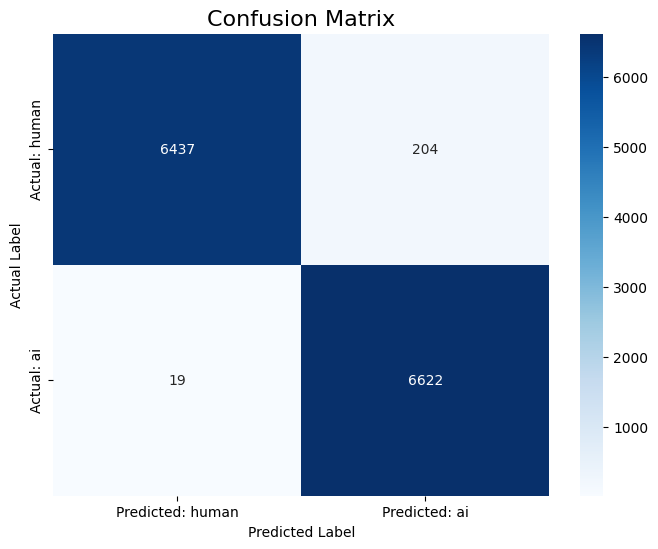

In [9]:
# %%
# =================================================================================
# 5. 메인 실행 블록 (수정)
# =================================================================================
if __name__ == '__main__':
    if DO_TRAINING:
        # 1. 훈련 시작 및 결과 저장
        results_df = run_training()

        # 2. 훈련 결과 시각화 및 CSV 저장
        if not results_df.empty:
            print("\n" + "="*50); print("              종합 훈련 결과 요약"); print("="*50)
            
            # --- [핵심] CSV 파일 저장 ---
            output_csv_path = f"{checkpoint_dir}_results.csv"
            results_df.to_csv(output_csv_path, index=False, float_format="%.4f")
            print(f"✅ 훈련 결과가 '{output_csv_path}' 파일로 저장되었습니다.")
            # ---------------------------

            display(results_df.style.format("{:.4f}", subset=results_df.columns.drop("Epoch")))
            
            # 그래프 생성
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
            ax1.plot(results_df["Epoch"], results_df["Train Loss"], marker='o', label="Train Loss")
            ax1.set_title("Model Loss per Epoch"); ax1.set_xlabel("Epoch"); ax1.set_ylabel("Loss"); ax1.legend(); ax1.grid(True)
            for col in ['Val Accuracy', 'Val Precision', 'Val Recall', 'Val F1']:
                ax2.plot(results_df["Epoch"], results_df[col], marker='o', label=col)
            ax2.set_title("Model Performance per Epoch"); ax2.set_xlabel("Epoch"); ax2.set_ylabel("Score"); ax2.legend(); ax2.grid(True)
            plt.tight_layout(); plt.show()
        
        # 3. 훈련된 최고 모델로 추론 실행
        list_of_folders = glob.glob(os.path.join(checkpoint_dir, "epoch*"))
        if list_of_folders:
            latest_folder = max(list_of_folders, key=os.path.getmtime)
            run_inference(latest_folder)
            run_final_evaluation(submission_file, test_csv)
        else:
            print("No trained model found to run inference.")
    else:
        # 4. 훈련 없이 지정된 모델로 추론 및 평가만 실행
        run_inference(ADAPTER_PATH_FOR_INFERENCE)
        run_final_evaluation(submission_file, test_csv)

In [12]:
results_df.to_csv("train_result_t5.csv", index=False)